# Efficient Frontier

The following code calculates an Efficient Frontier for up to six assets. The user can choose which assets they would like to incorporate into their portfolio. Options include: S&P 500, Fixed Income, Gold, Private Credit, Real Estate, and Private Equity. The user can also select the time frame of the historical data used in the calculation.

In [39]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
dropped_assets_string = input("Input the assets you would like to drop.\nMake sure to spell the assets correctly and separate each with a comma and a space.\nIf you do not want to drop any assets, simply press enter: ")

In [41]:
dropped_assets = dropped_assets_string.split(", ")
dropped_assets

['']

In [42]:
time_frame = input("Choose your desired time frame in years (1-10): ")

In [43]:
#Read in Data
asset_data = pd.read_csv("EF_Data_Summary.csv")
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,1/30/15,1994.99,1955.02,1283.79,933.11,317.41,1744.85
1,2/27/15,2104.50,1936.64,1213.18,987.22,308.89,1903.96
2,3/31/15,2067.89,1945.63,1183.57,979.69,310.75,1854.04
3,4/30/15,2085.51,1938.65,1184.37,989.70,295.33,1890.64
4,5/29/15,2107.39,1933.98,1190.58,989.64,293.95,1925.25
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [44]:
#drop rows of assets user does not want
if dropped_assets_string:
    asset_data = asset_data.drop(dropped_assets, axis=1)
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,1/30/15,1994.99,1955.02,1283.79,933.11,317.41,1744.85
1,2/27/15,2104.50,1936.64,1213.18,987.22,308.89,1903.96
2,3/31/15,2067.89,1945.63,1183.57,979.69,310.75,1854.04
3,4/30/15,2085.51,1938.65,1184.37,989.70,295.33,1890.64
4,5/29/15,2107.39,1933.98,1190.58,989.64,293.95,1925.25
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [45]:
#Create variable used to filter to desired time frame
included_rows = int(time_frame)*12
included_rows

72

In [46]:
#Filter to the desired time frame
asset_data = asset_data.tail(included_rows)
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
48,1/31/19,2704.10,2068.34,1321.25,1088.52,329.45,2699.58
49,2/28/19,2784.49,2067.14,1313.32,1112.94,331.42,2817.51
50,3/29/19,2834.40,2106.83,1292.38,1099.86,343.33,2831.09
51,4/30/19,2945.83,2107.37,1283.53,1137.90,342.66,2961.13
52,5/31/19,2752.06,2144.78,1305.58,1100.30,341.92,2626.64
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [47]:
#Convert users' selected assets into a list for later use
selected_assets = asset_data.columns.tolist()
#take out Month
selected_assets = [col for col in selected_assets if col != 'Month']
# add "Weight" for later use
selected_assets = [col + ' Weight' for col in selected_assets]
selected_assets

['S&P 500 Weight',
 'Fixed Income Weight',
 'Gold Weight',
 'Private Credit Weight',
 'Real Estate Weight',
 'Private Equity Weight']

In [48]:
#Add "monthly return" to all columns besides Month
asset_data.columns = [col + " Monthly Return" if col != "Month" else col for col in asset_data.columns]

# Make every value a pct change except for the 'Month' column
asset_data.loc[:, asset_data.columns != "Month"] = asset_data.loc[:, asset_data.columns != "Month"].pct_change()
asset_data

,Month,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
48,1/31/19,NaN,NaN,NaN,NaN,NaN,NaN
49,2/28/19,0.029729,-0.000580,-0.006002,0.022434,0.005980,0.043685
50,3/29/19,0.017924,0.019200,-0.015944,-0.011753,0.035936,0.004820
51,4/30/19,0.039313,0.000256,-0.006848,0.034586,-0.001951,0.045933
52,5/31/19,-0.065778,0.017752,0.017179,-0.033043,-0.002160,-0.112960
...,...,...,...,...,...,...,...
115,8/30/24,0.022835,0.014367,0.022794,-0.016757,0.053403,0.029783
116,9/30/24,0.020197,0.013391,0.052405,0.001391,0.026700,0.029719
117,10/31/24,-0.009897,-0.024799,0.041521,-0.007069,-0.036438,-0.021588
118,11/29/24,0.057301,0.010571,-0.036742,0.031647,0.039382,0.083202


In [49]:
#Remove unwanted data and drop first row
asset_data_returns = asset_data.loc[:, asset_data.columns.str.contains("Return")]
asset_data_returns = asset_data_returns.dropna()
asset_data_returns                                                         

,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
49,0.029729,-0.000580,-0.006002,0.022434,0.005980,0.043685
50,0.017924,0.019200,-0.015944,-0.011753,0.035936,0.004820
51,0.039313,0.000256,-0.006848,0.034586,-0.001951,0.045933
52,-0.065778,0.017752,0.017179,-0.033043,-0.002160,-0.112960
53,0.068930,0.012556,0.079635,0.021312,0.012167,0.128225
...,...,...,...,...,...,...
115,0.022835,0.014367,0.022794,-0.016757,0.053403,0.029783
116,0.020197,0.013391,0.052405,0.001391,0.026700,0.029719
117,-0.009897,-0.024799,0.041521,-0.007069,-0.036438,-0.021588
118,0.057301,0.010571,-0.036742,0.031647,0.039382,0.083202


In [50]:
#Calculate Avg Monthly Returns and Annualize it
expected_returns = asset_data_returns.mean()
expected_returns = (1 + expected_returns)**12 - 1
expected_returns

S&P 500 Monthly Return           0.157213
Fixed Income Monthly Return      0.011488
Gold Monthly Return              0.133741
Private Credit Monthly Return    0.081724
Real Estate Monthly Return       0.034805
Private Equity Monthly Return    0.164516
dtype: float64

In [51]:
#Calculate Covariance Matrix and Annualize it
cov_matrix = asset_data_returns.cov() * 12
cov_matrix

,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
S&P 500 Monthly Return,0.029963,0.005236,0.005336,0.029349,0.029378,0.049147
Fixed Income Monthly Return,0.005236,0.003732,0.003671,0.003544,0.007640,0.008056
Gold Monthly Return,0.005336,0.003671,0.019878,0.000839,0.007978,0.008244
Private Credit Monthly Return,0.029349,0.003544,0.000839,0.047735,0.032546,0.047910
Real Estate Monthly Return,0.029378,0.007640,0.007978,0.032546,0.040622,0.046984
Private Equity Monthly Return,0.049147,0.008056,0.008244,0.047910,0.046984,0.088921


In [52]:
#Primary Calculations
n = len(cov_matrix)
weights = cp.Variable(n)
weights

Variable((6,), var823)

In [53]:
#Calculate Target Returns
target_returns = np.linspace(
expected_returns.min(),
expected_returns.max(),
10 # Number of points on the frontier
)
target_returns

array([0.01148756, 0.02849071, 0.04549385, 0.062497  , 0.07950014,
       0.09650329, 0.11350643, 0.13050958, 0.14751272, 0.16451587])

In [54]:
# Store results
efficient_portfolios = []
for target_return in target_returns:
    # Objective: Minimize portfolio variance
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    # Constraints
    constraints = [
        weights >= 0, # No short-selling
        cp.sum(weights) == 1, # Fully invested
        expected_returns.values @ weights >= target_return # Target return
        ]
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    if prob.status == 'optimal':
        annualized_return = expected_returns.values @ weights.value
        annualized_variance = portfolio_variance.value
        efficient_portfolios.append({
            'Weights': weights.value,
            'Return': annualized_return,
            'Variance': annualized_variance
            })

In [55]:
# Convert to DataFrame
efficient_frontier = pd.DataFrame(efficient_portfolios)
efficient_frontier['Standard Deviation'] = np.sqrt(efficient_frontier['Variance'])
# Remove duplicates (if any)
efficient_frontier = efficient_frontier.drop_duplicates(['Return', 'Variance'])
efficient_frontier

,Weights,Return,Variance,Standard Deviation
0,"[-4.516324868254392e-22, 0.9910502866024858, 0...",0.012348,0.003730,0.061077
1,"[2.4632501315822466e-23, 0.8462436961148772, 0...",0.028491,0.003967,0.062981
2,"[0.06871712843944036, 0.7282395765194359, 0.18...",0.045494,0.004642,0.068130
3,"[0.14029174795405708, 0.6096920641741429, 0.25...",0.062497,0.005609,0.074891
4,"[0.19849292348153502, 0.48178530368287953, 0.3...",0.079500,0.006888,0.082996
5,"[0.2566940990090128, 0.3538785431916164, 0.389...",0.096503,0.008486,0.092120
6,"[0.31489527453649063, 0.22597178270035317, 0.4...",0.113506,0.010402,0.101990
7,"[0.3730964500639686, 0.09806502220908984, 0.52...",0.130510,0.012636,0.112409
8,"[0.5867282330735375, 2.7173059302432337e-22, 0...",0.147513,0.016298,0.127663
9,"[3.2636324479365203e-06, 2.1479464923735818e-0...",0.164515,0.088920,0.298194


In [56]:
# Split the 'Weights' into independent columns
efficient_frontier[selected_assets] = pd.DataFrame(efficient_frontier['Weights'].tolist(), index=efficient_frontier.index)

# Convert weights to percentages
efficient_frontier = efficient_frontier * 100

# Add '%' to the asset column names
efficient_frontier.columns = [f"{col} (%)" if 'Weight' in col else col for col in efficient_frontier.columns]

# Round the values to 2 decimal places
efficient_frontier = efficient_frontier.round(2)

# Change the index to 'Portfolio X' format
efficient_frontier.index = [f"Portfolio {i+1}" for i in range(len(efficient_frontier))]

# Rename columns
efficient_frontier = efficient_frontier.rename(columns={'Return': 'Expected Return (%)', 
                                                       'Variance': 'Variance (%)', 
                                                       'Standard Deviation': 'Standard Deviation (%)'})
#Drop Weights columns
efficient_frontier = efficient_frontier.drop("Weights (%)", axis=1)

#Drop Var Column
efficient_frontier = efficient_frontier.drop("Variance (%)", axis=1)
efficient_frontier

,Expected Return (%),Standard Deviation (%),S&P 500 Weight (%),Fixed Income Weight (%),Gold Weight (%),Private Credit Weight (%),Real Estate Weight (%),Private Equity Weight (%)
Portfolio 1,1.23,6.11,-0.00,99.11,0.45,0.45,-0.0,0.0
Portfolio 2,2.85,6.30,0.00,84.62,11.93,3.45,0.0,0.0
Portfolio 3,4.55,6.81,6.87,72.82,18.71,1.60,-0.0,-0.0
Portfolio 4,6.25,7.49,14.03,60.97,25.00,0.00,0.0,0.0
Portfolio 5,7.95,8.30,19.85,48.18,31.97,0.00,0.0,0.0
Portfolio 6,9.65,9.21,25.67,35.39,38.94,0.00,0.0,0.0
Portfolio 7,11.35,10.20,31.49,22.60,45.91,0.00,0.0,0.0
Portfolio 8,13.05,11.24,37.31,9.81,52.88,0.00,0.0,0.0
Portfolio 9,14.75,12.77,58.67,0.00,41.33,0.00,0.0,0.0
Portfolio 10,16.45,29.82,0.00,0.00,0.00,0.00,0.0,100.0


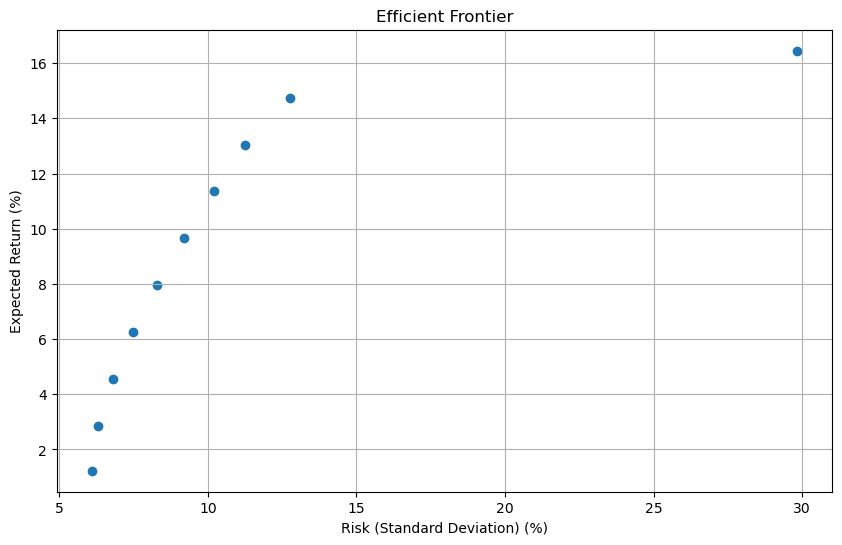

In [ ]:
#Graph
plt.figure(figsize=(10, 6))
plt.scatter(
    efficient_frontier['Standard Deviation (%)'],
    efficient_frontier['Expected Return (%)'],
    marker='o'
)
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation) (%)')
plt.ylabel('Expected Return (%)')
plt.grid(True)
plt.show()